<h1 style="font-size:42px; text-align:center; margin-bottom:30px;"><span style="color:SteelBlue">Machine Learning from End to End </span> </h1>
<h1 style="font-size:42px; text-align:center; margin-bottom:30px;">Home Price Forecasting: A Regression Problem, Part 4: Model Training</h1>

### In this module...

First, we'll load our analytical base table from Part 3. Then, we'll go through the essential modeling steps:

1. [Split your dataset](#split)
2. [Build model pipelines](#pipelines)
3. [Declare hyperparameters to tune](#hyperparameters)
4. [Fit and tune models with cross-validation](#fit-tune)
5. [Evaluate metrics and select winner](#evaluate)

Finally, we'll save the best model as a project deliverable!

<br><hr>

### First, let's import libraries, recruit models, and load the analytical base table.

Let's import our libraries and load the dataset. It's good practice to keep all of your library imports at the top of your notebook or program.

In [1]:
# Computing libraries
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 100)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Visualization libraries
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline 

# Scikit-Learn for Modeling
import sklearn
# Import Elastic Net, Ridge Regression, and Lasso Regression, Random Forest and Gradient Boosted Trees models
from sklearn.linear_model import ElasticNet, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# sklearn modules for model training
# includes modules for splitting training and test set, pipeline creation, standardization, cross-validation
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

# Classification metrics for model performance evaluation
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix

In [2]:
# Load cleaned dataset from Module 3
df = pd.read_csv('/Users/brandonlewis/Desktop/Elite Data Science/Project 2 Workbook Bundle/analytical_base_table.csv')

print(df.shape)

(1617, 40)


<br id="split">
# 1. Split your dataset

I'll start by splitting the data into separate training and test sets. Splitting into test/train sets helps us to minimize the chances of our models overfitting the data by making sure some data is set aside for testing model performance instead of all the data being used to train the model. For this problem I will separate the dataframe into separate objects for the target variable <code style="color:steelblue">y</code>, and the input features, <code style="color:steelblue">X</code>.

Once I've created my target variable and feature objects I then use the <code style="color:steelblue">train_test_split()</code> function to split <code style="color:steelblue">X</code> and <code style="color:steelblue">y</code> into training and test sets. I choose to set aside 20% of the observations for the test set, set a <code style="color:steelblue">random_state</code> variabel to ensure replicable results. Most importantly, I pass the argument <code style="color:steelblue">stratify=</code><span style="color:crimson">df.tx_price</span></code> to make sure the target variable's classes are balanced in each subset of data so that we have **stratified random sampling**. This ensures that each of my divided subsets are truly random and the performance I get from my cross-validation is truly representative of my entire training data set. At the end I pring the nubmer of observations in each subset to check that the splitting was done correctly. Next, when we train our models, we can fit them on the <code style="color:steelblue">X_train</code> feature values and <code style="color:steelblue">y_train</code> target values.

Finally, when we're ready to evaluate our models on our test set, we would use the trained models to predict <code style="color:steelblue">X_test</code> and evaluate the predictions against <code style="color:steelblue">y_test</code>.

In [3]:
# Create separate object for target variable
y = df.tx_price
# Create separate object for input features
X = df.drop('tx_price', axis=1)

# Split X and y into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

# Confirm right number of observations in each subset
print( len(X_train), len(X_test), len(y_train), len(y_test) )

1293 324 1293 324


<div style="text-align:center; margin: 40px 0 40px 0;">
[**Back to Contents**](#toc)
</div>

<br id="pipelines">
# 2. Build model pipelines

Next, let's set up preprocessing pipelines for each of our algorithms. I use the keys below for each algorithm in my dictionary. Each pipeline is standardized first before the algorithm is run. Scaling the data sets so they all have a normal distribution centered around zero prevents any large scaling differences in the data affecting the model performance. Lastly, I set the <code style="color:steelblue">random_state</code> variable for each algorithm to ensure replicable results.

In [21]:
# Create pipelines dictionary
pipelines = {
    'lasso' : make_pipeline(StandardScaler(), Lasso(random_state=1234)),
    'ridge' : make_pipeline(StandardScaler(), Ridge(random_state=1234)),
    'enet' : make_pipeline(StandardScaler(), ElasticNet(random_state=1234)),
    'rf' : make_pipeline(StandardScaler(), RandomForestRegressor(random_state=1234)),
    'gb' : make_pipeline(StandardScaler(), GradientBoostingRegressor(random_state=1234))
}

Let's make sure our dictionary has pipelines for each of our algorithms.

In [5]:
# Check that we have all 5 algorithms, and that they are all pipelines
for key, value in pipelines.items():
    print( key, type(value) )

lasso <class 'sklearn.pipeline.Pipeline'>
ridge <class 'sklearn.pipeline.Pipeline'>
enet <class 'sklearn.pipeline.Pipeline'>
rf <class 'sklearn.pipeline.Pipeline'>
gb <class 'sklearn.pipeline.Pipeline'>


Now that we have our pipelines, we're ready to move on to declaring hyperparameters to tune.

<div style="text-align:center; margin: 40px 0 40px 0;">
[**Back to Contents**](#toc)
</div>


<br id="hyperparameters">
# 3. Declare hyperparameters to tune
Next, let's declare hyperparameters to tune. I start off by listing the tuneable hyperparameters of the logistic pipeline. There are many listed but usually only one or two are needed for tuning to optimize performance. I declare these hyperparameter grids next for each algorithm. Then I create a hyperparameter dictionary which uses the same keys of the pipeline dictionary I created above to store them all. Having both the pipelines and the hyperparameters in dictionary form will make the cross-validation step very straightforward. Finally, I run a loop checking that all the hyperparameters are set up correctly.

In [22]:
# List tuneable hyperparameters of our Lasso pipeline
pipelines['lasso'].get_params()

{'lasso': Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
    normalize=False, positive=False, precompute=False, random_state=1234,
    selection='cyclic', tol=0.0001, warm_start=False),
 'lasso__alpha': 1.0,
 'lasso__copy_X': True,
 'lasso__fit_intercept': True,
 'lasso__max_iter': 1000,
 'lasso__normalize': False,
 'lasso__positive': False,
 'lasso__precompute': False,
 'lasso__random_state': 1234,
 'lasso__selection': 'cyclic',
 'lasso__tol': 0.0001,
 'lasso__warm_start': False,
 'memory': None,
 'standardscaler': StandardScaler(copy=True, with_mean=True, with_std=True),
 'standardscaler__copy': True,
 'standardscaler__with_mean': True,
 'standardscaler__with_std': True,
 'steps': [('standardscaler',
   StandardScaler(copy=True, with_mean=True, with_std=True)),
  ('lasso', Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=1234,
      selection='cyclic', tol=0.0001, warm_start=False)

In [7]:
# Lasso hyperparameters
lasso_hyperparameters = {
    'lasso__alpha' : [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10]
}
# Ridge hyperparameters
ridge_hyperparameters = {
    'ridge__alpha' : [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10]
}
# Elastic Net hyperparameters
enet_hyperparameters = {
    'elasticnet__alpha' : [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10],
    'elasticnet__l1_ratio' : [0.1, 0.3, 0.5, 0.7, 0.9]
}
# Random forest hyperparameters
rf_hyperparameters = {
    'randomforestregressor__n_estimators' : [100, 200],
    'randomforestregressor__max_features' : ['auto', 'sqrt', 0.33]
}
# Boosted tree hyperparameters
gb_hyperparameters = {
    'gradientboostingregressor__n_estimators' : [100, 200],
    'gradientboostingregressor__learning_rate' : [0.05, 0.1, 0.2],
    'gradientboostingregressor__max_depth' : [1, 3, 5]
}

In [8]:
# Create hyperparameters dictionary
hyperparameters = {
    'lasso' : lasso_hyperparameters,
    'ridge' : ridge_hyperparameters,
    'enet' : enet_hyperparameters,
    'rf' : rf_hyperparameters,
    'gb' : gb_hyperparameters
}

In [23]:
for key in hyperparameters:
    if key in hyperparameters:
        if type(hyperparameters[key]) is dict:
            print( key, 'was found in hyperparameters, and it is a grid.' )
        else:
            print( key, 'was found in hyperparameters, but it is not a grid.' )
    else:
        print( key, 'was not found in hyperparameters')

lasso was found in hyperparameters, and it is a grid.
ridge was found in hyperparameters, and it is a grid.
enet was found in hyperparameters, and it is a grid.
rf was found in hyperparameters, and it is a grid.
gb was found in hyperparameters, and it is a grid.


<div style="text-align:center; margin: 40px 0 40px 0;">
[**Back to Contents**](#toc)
</div>

<br id="fit-tune">
# 4. Fit and tune models with cross-validation

Now that we have our <code style="color:steelblue">pipelines</code> and <code style="color:steelblue">hyperparameters</code> dictionaries declared, we're ready to tune our models with **cross-validation**.

For this task I start by creating an empty <code style="color:SteelBlue">fitted_models</code> dictionary that will include models that have been tuned using cross-validation. The keys will be the same as those in the <code style="color:SteelBlue">pipelines</code> and <code style="color:SteelBlue">hyperparameters</code> dictionaries. The values will be <code style="color:steelblue">GridSearchCV</code> objects that have been fitted to <code style="color:steelblue">X_train</code> and <code style="color:steelblue">y_train</code>. After fitting each model, I will print <code style="color:crimson">'{name} has been fitted.'</code> just to track the progress. To speed up processing time I set <code style="color:steelblue">n_jobs=<span style="color:crimson">-1</span></code> to use as many cores as available on my computer. I then run a couple of loops to check that all the models have been fitted and that they are of the correct type.

In [24]:
# Create empty dictionary called fitted_models
fitted_models = {}

# Loop through model pipelines, tuning each one and saving it to fitted_models
for name, pipeline in pipelines.items():
    # Create cross-validation object from pipeline and hyperparameters
    model = GridSearchCV(pipeline, hyperparameters[name], cv=10, n_jobs=-1)
    
    # Fit model on X_train, y_train
    model.fit(X_train, y_train)
    
    # Store model in fitted_models[name] 
    fitted_models[name] = model
    
    # Print '{name} has been fitted'
    print(name, 'has been fitted.')

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of

lasso has been fitted.
ridge has been fitted.


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of

enet has been fitted.
rf has been fitted.
gb has been fitted.


In [11]:
# Check that we have 5 cross-validation objects
for key, value in fitted_models.items():
    print( key, type(value) )

lasso <class 'sklearn.model_selection._search.GridSearchCV'>
ridge <class 'sklearn.model_selection._search.GridSearchCV'>
enet <class 'sklearn.model_selection._search.GridSearchCV'>
rf <class 'sklearn.model_selection._search.GridSearchCV'>
gb <class 'sklearn.model_selection._search.GridSearchCV'>


In [12]:
from sklearn.exceptions import NotFittedError

for name, model in fitted_models.items():
    try:
        pred = model.predict(X_test)
        print(name, 'has been fitted.')
    except NotFittedError as e:
        print(repr(e))

lasso has been fitted.
ridge has been fitted.
enet has been fitted.
rf has been fitted.
gb has been fitted.


Nice. Now we're ready to evaluate how our models performed!

<hr style="border-color:royalblue;background-color:royalblue;height:1px;">

<div style="text-align:center; margin: 40px 0 40px 0;">
[**Back to Contents**](#toc)
</div>

<br id="evaluate">
# 5. Evaluate models and select winner

Finally, it's time to evaluate our models and pick the best one. Here I create a for loop which calculates the <code style="color:steelblue">best\_score_</code> attribute for each fitted model. As you can see, the ensemble tree algorithms had the best performance with Gradient Boosted Trees model getting the highest score followed by Random Forest, the generic Elastic Net model, and then the two specialized regression models, Ridge and Lasso. 

For comparison sake I'm also going to run a loop to print out the $R^2$ and MAE scores for each model to see how they compare to the <code style="color:steelblue">best\_score_</code> attribute for each fitted model. You can see the ranking stays the same for the $R^2$ error but is altered a bit for the regression models in the MAE score. Either way, we have two models which meet our win condition of MAE < $70,000. The winner is the model with the smallest MAE: Gradient Boosted Trees.

In [25]:
# Display best_score_ for each fitted model
for name, model in fitted_models.items():
    print(name, model.best_score_)

lasso 0.32542435623175286
ridge 0.3320098300677493
enet 0.34968315167630615
rf 0.5075575924244231
gb 0.5147041073771785


In [14]:
# Loop to print performance of eac model in fitted_models on test set
for name, model in fitted_models.items():
    pred = model.predict(X_test)
    print(name)
    print('--------')    
    print('R2:', r2_score(y_test, pred))
    print('MAE:', mean_absolute_error(y_test, pred))
    print()

lasso
--------
R2: 0.46107992590426183
MAE: 87896.62808542959

ridge
--------
R2: 0.46189804880835483
MAE: 87901.5060458523

enet
--------
R2: 0.4623439428588939
MAE: 89151.94485944425

rf
--------
R2: 0.5619897900660522
MAE: 77916.57688271605

gb
--------
R2: 0.5767998680942463
MAE: 76853.50216161327



**Finally, let's plot the performance of the winning model on the test set. Run the code below.**
* It first plots a scatter plot.
* Then, it plots predicted transaction price on the X-axis.
* Finally, it plots actual transaction price on the y-axis.

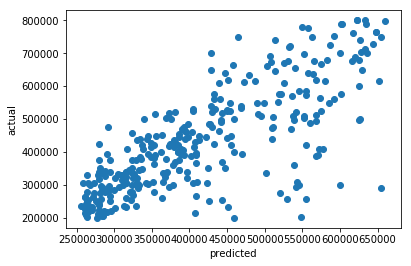

In [15]:
gb_pred = fitted_models['gb'].predict(X_test)
plt.scatter(gb_pred, y_test)
plt.xlabel('predicted')
plt.ylabel('actual')
plt.show()

This last visual check is a nice way to confirm our model's performance.

<div style="text-align:center; margin: 40px 0 40px 0;">
[**Back to Contents**](#toc)
</div>

<br>
### Finally, let's save the winning model.

Great job! You've created a pretty kick-ass model for real-estate valuation. Now it's time to save your hard work.

First, let's take a look at the data type of your winning model.

***Run each code cell below after completing the exercises above.***

If we output that object directly, we can also see the winning values for our hyperparameters.

In [18]:
fitted_models['gb'].best_estimator_

Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('gradientboostingregressor', GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.05, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, m...rs=100, presort='auto', random_state=123,
             subsample=1.0, verbose=0, warm_start=False))])

See? The winning values for our hyperparameters are:
* <code style="color:steelblue">n_estimators: <span style="color:crimson">200</span></code>
* <code style="color:steelblue">max_features : <span style="color:crimson">'auto'</span></code>

Great, now let's import a helpful package called <code style="color:steelblue">pickle</code>, which saves Python objects to disk.

In [19]:
import pickle

Let's save the winning <code style="color:steelblue">Pipeline</code> object into a pickle file.

In [20]:
with open('final_model.pkl', 'wb') as f:
    pickle.dump(fitted_models['gb'].best_estimator_, f)

As a reminder, here are a few things you did in this module:
* Split your dataset into separate training and test sets.
* Set up preprocessing pipelines.
* Tuned the models using cross-validation.
* Evaluated your models, selecting and saving the winner.

<div style="text-align:center; margin: 40px 0 40px 0;">
[**Back to Contents**](#toc)
</div>
